# Numba: don't be afraid of for-loops

A just-in-time (jit) compiler for numpy-based programs.

Useful for
1. cpu-intensive computations
2. programs with many for-loops (use with care)

In [1]:
import numpy as np
from numba import njit

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

## Function definition

In [3]:
def f(x):
    return x

In [4]:
f

<function __main__.f(x)>

## Njit

In [546]:
@njit
def f(x):
    return x

In [547]:
f

CPUDispatcher(<function f at 0x7fe6bd27bf60>)

## Numba by example: particle-swarm optimisation (PSO)
$$
    f(x,y) = \sin\left(\frac{1}{2}x^2 - \frac{1}{4}y^2 + 3 \right) \cos(2x + 1 - \exp(y))
$$

In [548]:
@njit
def f(X):
    x, y = X
    t1 = np.sin(x ** 2 / 2 - y ** 2 / 4 + 3)
    t2 = np.cos(2 * x + 1 - np.exp(y))
    return t1 * t2

In [549]:
X = np.mgrid[-5:4:0.05, -5:3:0.05]
Z = f(X)

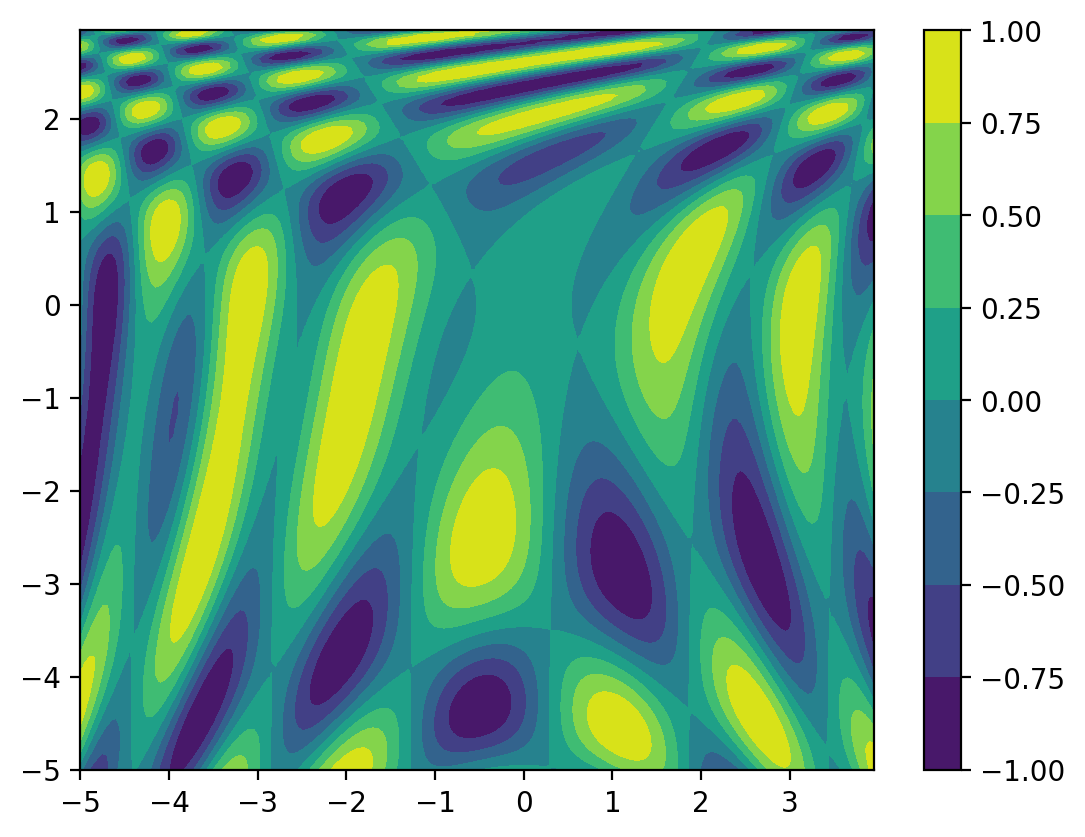

In [550]:
plt.contourf(*X, Z)
plt.colorbar()

## The PSO algorithm

In this exercise, we implement the Swarm Optimisation (PSO) algorithm for finding the minimum of a function $f: \mathbb{R}^M \to \mathbb{R}$.

Particle swarm optimization (PSO) is a stochastic population-based optimization method proposed by Kennedy and Eberhart (1995). PSO is a variant of an unconstraint optimisation problem which is defined as the following problem

$$
\text{find }{\bf x}^* \in S \subseteq \mathbb{R} \text{ such that }\forall {\bf x}\in S. f({\bf x}^*) \leq f({\bf x})
$$

Where

* $S$ is the search space
* $\{f(x)|x∈S\}$ is the landscape of the problem


## The configuration

The  PSO algorithm implemented in this notebook considers a collection (swarm) of $N$ particles at time $t$ as a tuple $P_t = \{({\bf x}_{n,t}, {\bf v}_{n,t}, {\bf p}_{n,t})\}_{n=1}^N$

where
* ${\bf x}_{n,t} \in \mathbb{R}^M$ is the **position** of the $n$-particle at time $t$
* ${\bf v}_{n,t}  \in \mathbb{R}^M$ is the **velocity** of the $n$-particle at time $t$. Is specifies the direction and lenght of the movement of the $n$-th particle
* ${\bf p}_{n,t}  \in \mathbb{R}^M$ is the **best position** of the $n$-particle at time $t$, i.e., $ \forall \tau \leq t . f({\bf p}_{n,t}) \leq f({\bf x}_{n,\tau})$

We also consider an aditional element
* ${\bf g}_t$ as the **best global vector** at iteration $t$., i.e., 

$$
    \forall \tau \leq t.\forall n\in\{1,\ldots, N\} f({\bf g}_{t}) \leq f({\bf x}_{n,\tau})
$$

---

### Initialisiation
At time $t=0$, the swarm is initialised as follows:

* Define $b_\text{low}$, $b_\text{up}$, and $v_\text{init}$
* $\forall n.$ initialise ${\bf x}_{n,0}$ as an $M$-dimensional uniformly-distributed random vector between $b_\text{low}$ and $b_\text{up}$
* $\forall n.$ initialise ${\bf p}_{n,0} := {\bf x}_{n,0}$
* Define ${\bf g}_0 \in P_0$ such that $f({\bf g}_0) = \min_n f({\bf x}_{n,0})$

In [562]:
def initialise_swarm(f, dim, b_up, b_down, n_particles):
    v_init = np.abs(b_up - b_down)
    
    positions = np.random.uniform(b_down, b_up, size=(n_particles, dim))
    velocities = np.random.uniform(-v_init, v_init, size=(n_particles, dim))
    positions_best = positions.copy()
    
    position_best_global = positions_best[0]
    position_best_global, f_star = find_best_position(positions, position_best_global, f)

    return (positions, velocities, positions_best), position_best_global

### Update rule

At time $t+1$, the $n$-th particle is updated as follows:
$$
\begin{align*}
    {\bf v}_{n,t+1} &= \omega {\bf v}_{n, t} + \phi_p r_p({\bf p}_{n, t} - {\bf x}_{n, t}) + \phi_g r_g ({\bf g}_{t} - {\bf x}_{n, t})\\
    {\bf x}_{n,t+1} &= {\bf x}_{n,t+1} + \alpha {\bf v}_{n,t+1}\\
    {\bf p}_{n,t+1} &= \begin{cases}
        x_{n, t+1} & f(x_{t, n+1}) < f(p_{t, n})\\
        p_{t, n} & \text{otherwise}
    \end{cases}
\end{align*}
$$

Then,
$$
{\bf g}_{t+1} =
    \begin{cases}
        x_{n, t+1} & f(x_{t, n+1}) < f(g_{t, n})\\
        g_{t} & \text{otherwise}
    \end{cases}
$$


Here,
* $\omega$ is the influence of previous velocity
* $\phi_p$ is the cognitive effect factor
* $\phi_g$ is the social influece factor
* $\alpha$ is the learning_rate
* $r_p \sim {\cal U}[0, 1]$
* $r_g \sim {\cal U}[0, 1]$

In [609]:
@njit
def find_best_position(best_positions, g_current, f):
    g_new = g_current.copy()
    for ix, position in enumerate(best_positions):
        if f(position) < f(g_current):
            g_new = position.copy()
    return g_new, f(g_new)


@njit
def update_particle(
    pos, vel, pos_best, pos_best_global,
    omega, phi_p, phi_g, alpha, f
):
    # rp, rg = np.random.uniform(size=2)
    rp = np.random.uniform()
    rg = np.random.uniform()
    
    vel_new = omega * vel + phi_p * rp * (pos_best - pos) + phi_g * rg * (pos_best_global - pos)
    pos_new = pos + alpha * vel_new

    if f(pos_new) < f(pos_best):
        pos_best_new = pos_new
    else:
        pos_best_new = pos_best

    return pos_new, vel_new, pos_best_new


@njit
def update_particles(
    positions, velocities, positions_best, position_best_global,
    omega, phi_p, phi_g, alpha, f
):
    positions = positions.copy()
    velocities = velocities.copy()
    positions_best = positions_best.copy()
    
    for n, (pos, vel, pos_best) in enumerate(zip(positions, velocities, positions_best)):
        pos_new, vel_new, pos_best_new = update_particle(
            pos, vel, pos_best, position_best_global,
            omega, phi_p, phi_g, alpha, f
        )
        positions[n] = pos_new
        velocities[n] = vel_new
        positions_best[n] = pos_best_new

    return positions, velocities, positions_best

@njit
def run_pso_hist(f, n_particles, dim, timesteps, positions, velocities, positions_best,
            position_best_global, omega, phi_p, phi_g, alpha, seed=314):
    positions_hist = np.zeros((timesteps, n_particles, dim))
    f_star_hist = np.zeros(timesteps)
    position_best_global_hist = np.zeros((timesteps, dim))
    
    for t in range(timesteps):
        np.random.seed(seed + t)
        positions, velocities, positions_best = update_particles(
            positions, velocities, positions_best, position_best_global,
            omega, phi_p, phi_g, alpha, f
        )
        
        find_best_position(positions, position_best_global, f)
        
        position_best_global, f_star = find_best_position(positions, position_best_global, f)
    
        positions_hist[t] = positions
        position_best_global_hist[t] = position_best_global
        f_star_hist[t] = f_star

    hist = positions_hist, position_best_global_hist, f_star_hist
    return positions_best, hist


@njit
def run_pso(f, n_particles, dim, timesteps, positions, velocities, positions_best,
            position_best_global, omega, phi_p, phi_g, alpha, seed=314):
    f_star_hist = np.zeros(timesteps)
    
    for t in range(timesteps):
        np.random.seed(seed + t)
        positions, velocities, positions_best = update_particles(
            positions, velocities, positions_best, position_best_global,
            omega, phi_p, phi_g, alpha, f
        )
        
        find_best_position(positions, position_best_global, f)
        
        position_best_global, f_star = find_best_position(positions, position_best_global, f)
        f_star_hist[t] = f_star
    
    return position_best_global, f_star_hist

In [783]:
influence_vel = 0.7 #0.01 # ω
cognitive_effect = 0.01 # ϕp
social_influence = 0.05 # ϕg
learning_rate = 0.15 #0.9 # α

dim = 2

In [784]:
# Initialisiation
n_particles = 20
b_down, b_up = -4, 3

np.random.seed(3141)
(positions, velocities, positions_best), position_best_global = initialise_swarm(f, dim, b_down, b_up, n_particles)

In [785]:
timesteps = 1000

In [786]:
positions_best, hist = run_pso_hist(
    f, n_particles, dim, timesteps, positions, velocities, positions_best, position_best_global,
    influence_vel, cognitive_effect, social_influence, learning_rate
)
positions_hist, position_best_global_hist, f_star_hist = hist

(-4.0, 3.0)

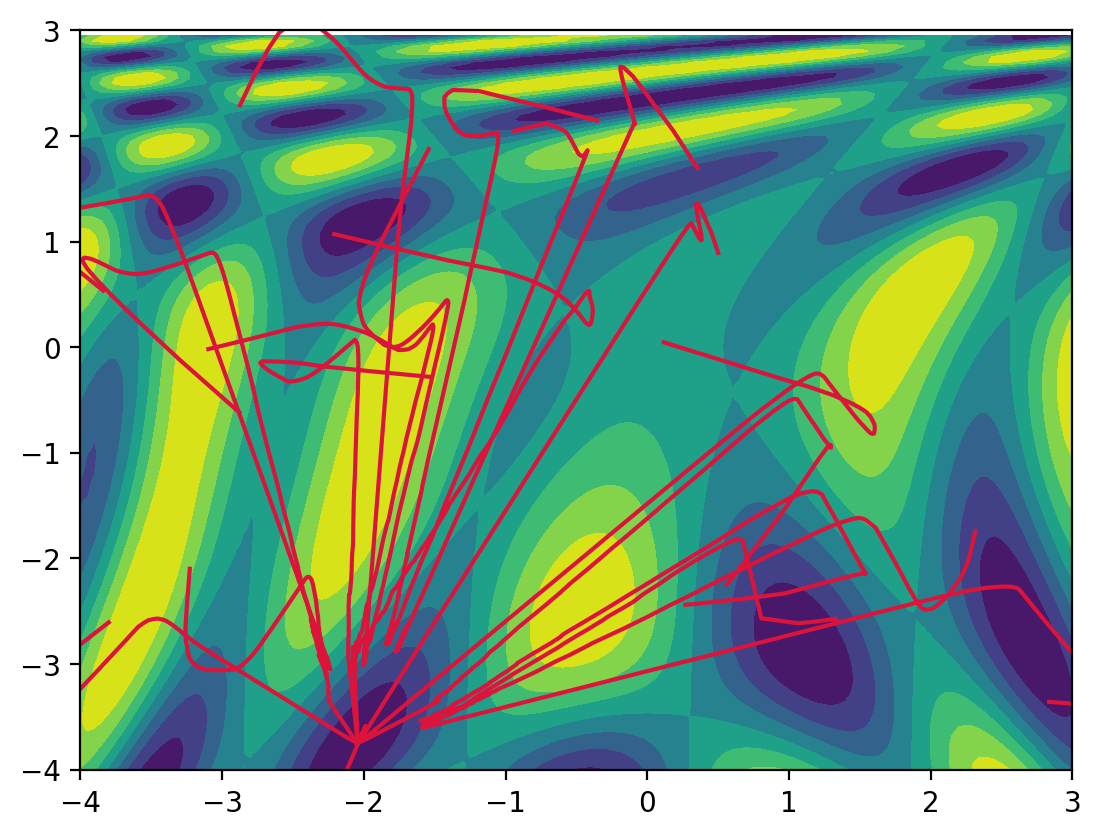

In [792]:
plt.contourf(*X, Z)

for p in range(n_particles):
    plt.plot(*positions_hist[:, p, :].T, c="crimson")

plt.xlim(b_down, b_up)
plt.ylim(b_down, b_up)
# plt.scatter(*positions_best.T, c="crimson")

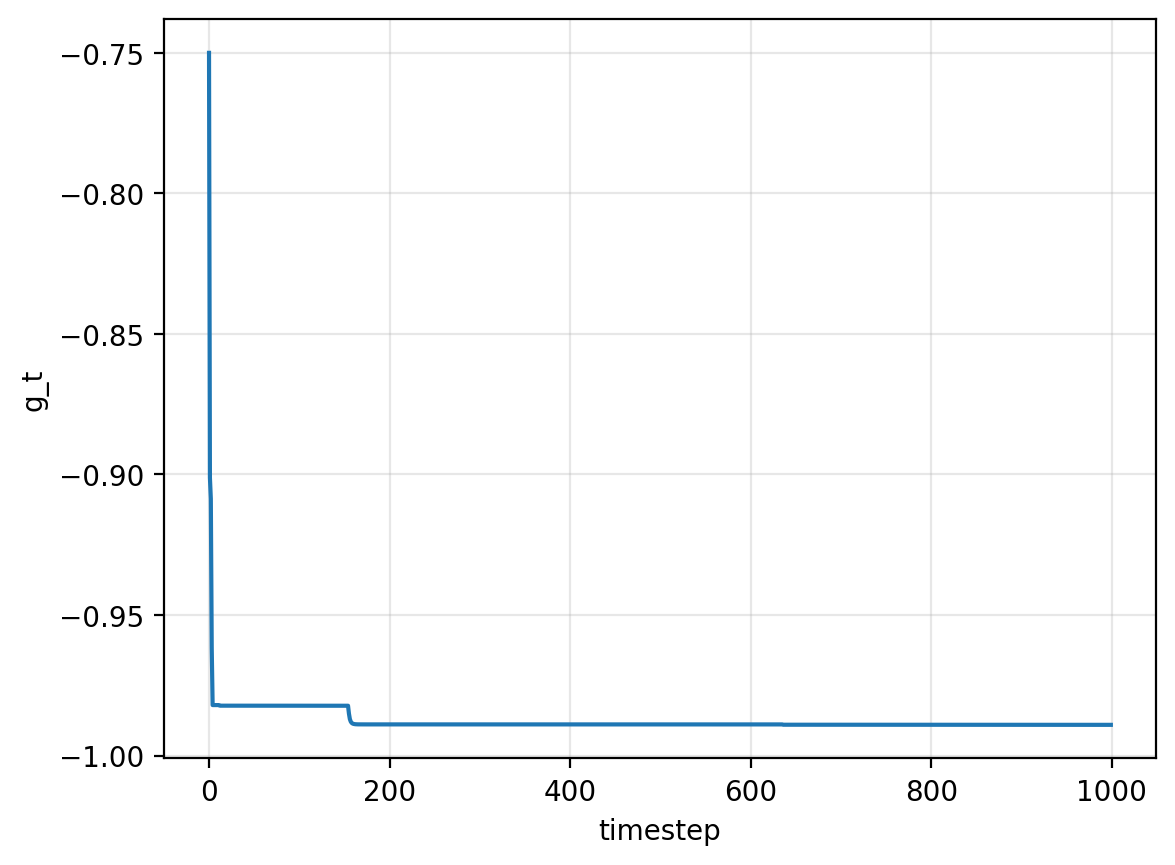

In [782]:
plt.plot(f_star_hist)
plt.xlabel("timestep")
plt.ylabel("g_t")
plt.grid(alpha=0.3)

## An animation

In [775]:
from matplotlib.animation import FuncAnimation

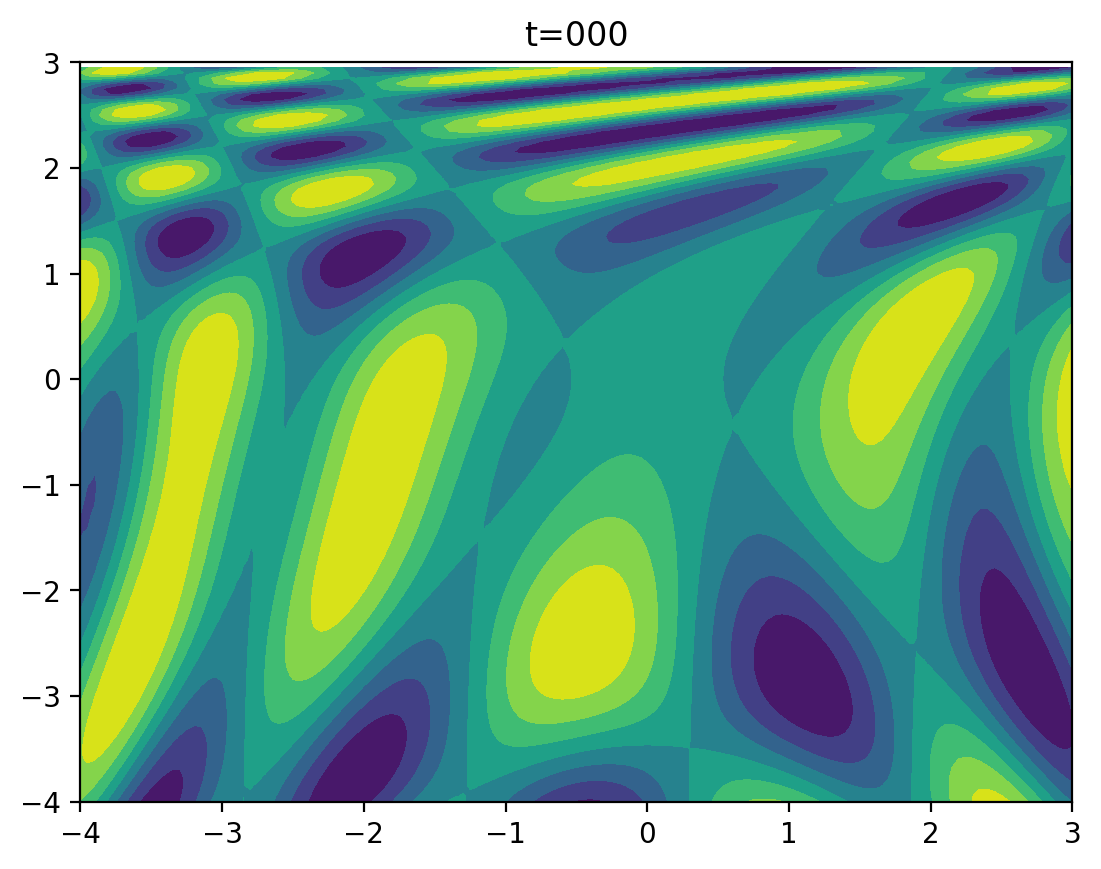

In [790]:
fig, ax = plt.subplots()
def plot_step(t):
    print(t, end="\r")
    ax.cla()
    plt.contourf(*X, Z)

    plt.title(f"t={t:03}")
    for p in range(n_particles):
        plt.plot(*positions_hist[:t, p, :].T, c="crimson")
    plt.xlim(b_down, b_up)
    plt.ylim(b_down, b_up)

frames = np.arange(0, 300, 2)
anim = FuncAnimation(fig, plot_step, frames=frames)
anim.save("swarm.gif", fps=20)

## Example: training a neural network with the particle swarm optimisator (PSO)

In [559]:
@njit
def fv(x):
    return 0.4 + 0.1 * x - 1.2 + np.sin(x) * x

In [560]:
n_samples = 200
np.random.seed(3141)
x = np.random.uniform(-5, 5, n_samples)
errs = np.random.randn(n_samples) * 0.4
y = fv(x) + errs

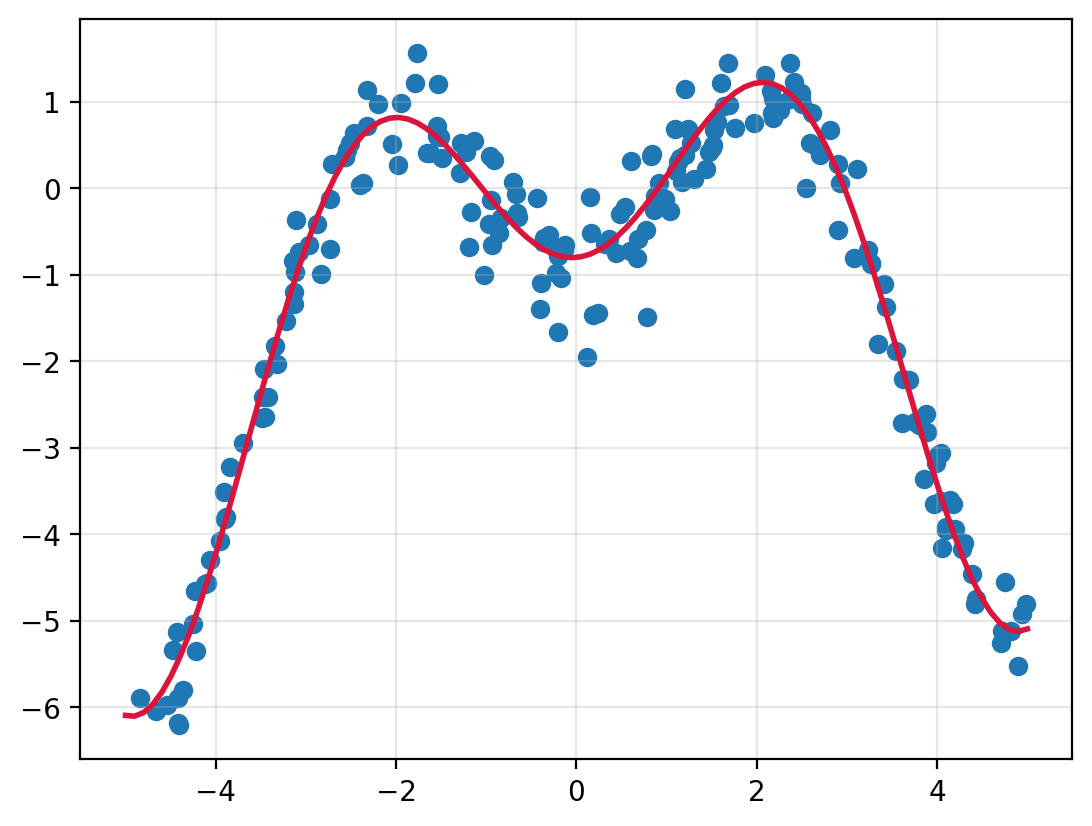

In [561]:
xrange = np.linspace(-5, 5, 100)
plt.plot(xrange, fv(xrange), c="crimson", linewidth=2)
plt.scatter(x, y)
plt.grid(alpha=0.3)

In [509]:
@njit
def mlp(weights, x):
    wl1 = weights[:10]
    b1 = weights[10]
    wl2 = weights[11:-3]
    b2 = weights[-3]
    wl3 = weights[-2]
    b3 = weights[-1]

    l1 = np.cos(wl1[:, None] @ x + b1)
    l2 = np.maximum(0, wl2[None, :] @ l1 + b2)
    out = wl3 * l2.reshape(1, -1) + b3
    return out

In [510]:
dim = 10 + 1 + 10 + 1 + 2
w = np.random.randn(dim)

In [511]:
@njit
def lossfn(weights):
    return np.sqrt(np.power(y - mlp(weights, x[None, :]).ravel(), 2).mean())

In [512]:
lossfn(w)

3.1154443543182104

## Train with swarm

In [535]:
influence_vel = 0.01 # ω
cognitive_effect = 0.01 # ϕp
social_influence = 0.05 # ϕg
learning_rate = 0.2 # α

In [536]:
# Initialisiation
n_particles = 100
b_down, b_up = -5, 5

np.random.seed(314)
(positions, velocities, positions_best), position_best_global = initialise_swarm(lossfn, dim, b_down, b_up, n_particles)

In [537]:
timesteps = 1500

In [538]:
%%time
w_star, f_star_hist = run_pso(
    lossfn, n_particles, dim, timesteps, positions, velocities, positions_best, position_best_global,
    influence_vel, cognitive_effect, social_influence, learning_rate
)

CPU times: user 35.8 s, sys: 205 ms, total: 36 s
Wall time: 35.8 s


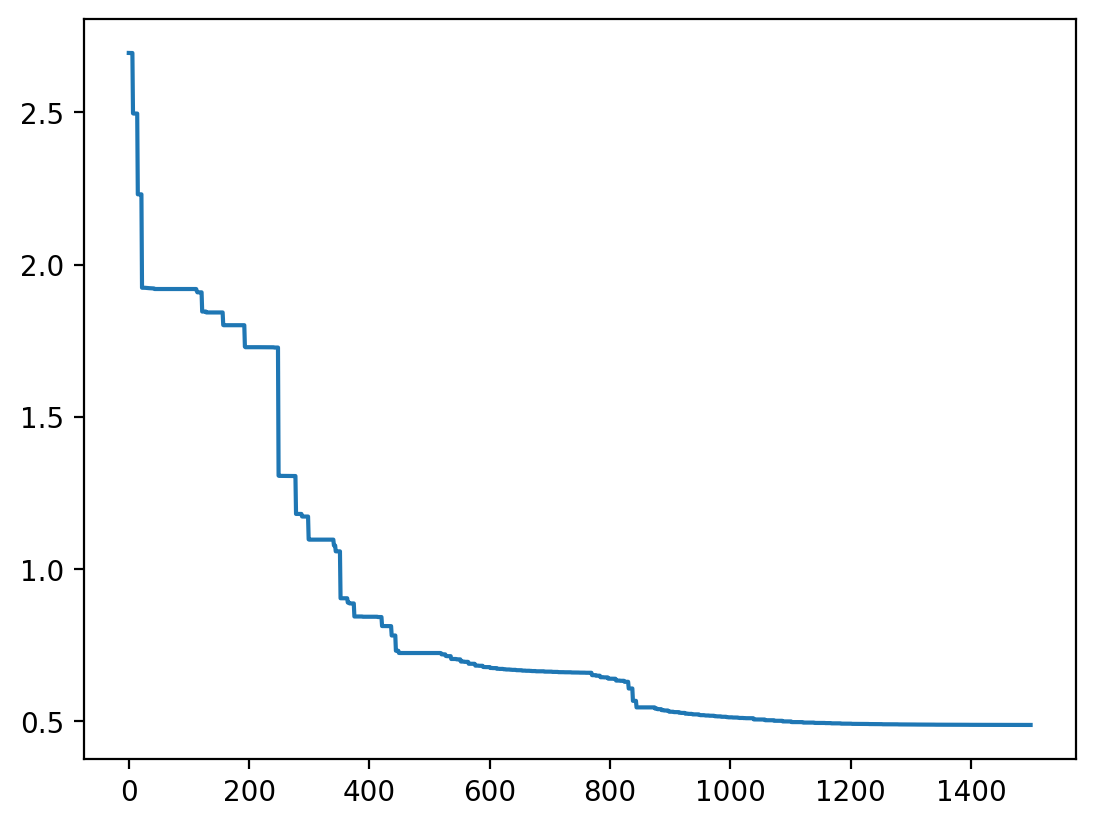

In [539]:
plt.plot(f_star_hist)

In [540]:
yhat = mlp(w_star, xrange[None, :]).ravel()

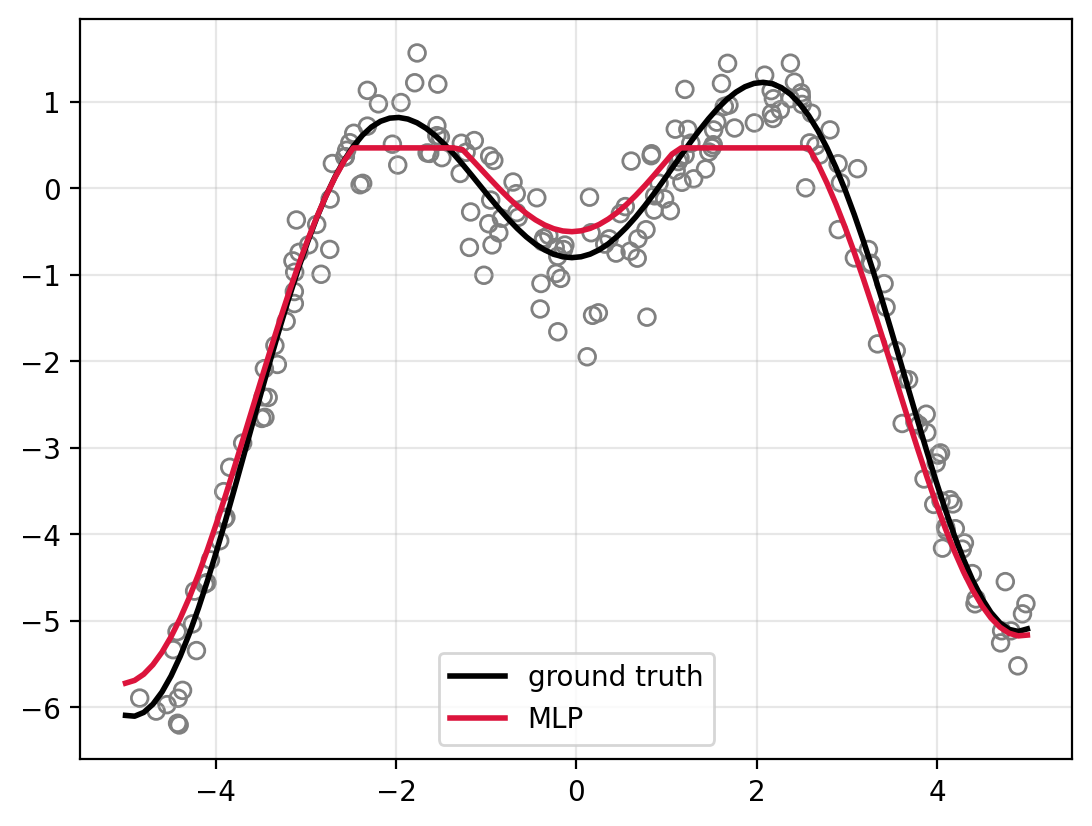

In [541]:
xrange = np.linspace(-5, 5, 100)
plt.plot(xrange, fv(xrange), c="black", linewidth=2, label="ground truth")
plt.plot(xrange, yhat, c="crimson", label="MLP", linewidth=2)
plt.scatter(x, y, c="none", edgecolor="gray")
plt.legend()
plt.grid(alpha=0.3)

## References

* M. R. Bonyadi and Z. Michalewicz, "Particle Swarm Optimization for Single Objective Continuous Space Problems: A Review," in Evolutionary Computation, vol. 25, no. 1, pp. 1-54, March 2017, doi: 10.1162/EVCO_r_00180.